# Read .bdf files and convert to .h5
For import to MATLAB and Python
Script performs the following:
- Read .bdf file
- Select only EEG channels/discard EOG, EMG
- Reference to the common average
- Clip off the noisy end of data
- Export to .h5

In [1]:
import os
import numpy as np
import mne
import pathlib
import matplotlib.pyplot as plt

In [2]:
path=pathlib.Path('/media/tris/tris_files/DEAP_dataset/data_original')
path

PosixPath('/media/tris/tris_files/DEAP_dataset/data_original')

In [3]:
raw=mne.io.read_raw_bdf(path/'s04.bdf')
raw.load_data()

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1690111  =      0.000 ...  3300.998 secs...


<RawEDF | s04.bdf, 48 x 1690112 (3301.0 s), ~619.0 MB, data loaded>

In [4]:
eeg_channels=raw.ch_names[0:32] #first 32 channels are the EEG ones
eeg_channels

['Fp1',
 'AF3',
 'F7',
 'F3',
 'FC1',
 'FC5',
 'T7',
 'C3',
 'CP1',
 'CP5',
 'P7',
 'P3',
 'Pz',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'P4',
 'P8',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'AF4',
 'Fp2',
 'Fz',
 'Cz']

In [5]:
eog_channels=raw.ch_names[32:36];eog_channels

['EXG1', 'EXG2', 'EXG3', 'EXG4']

In [6]:
emg_channels=raw.ch_names[36:40];emg_channels

['EXG5', 'EXG6', 'EXG7', 'EXG8']

In [7]:
raw.pick_channels(eeg_channels) #select only the EEG channels

<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

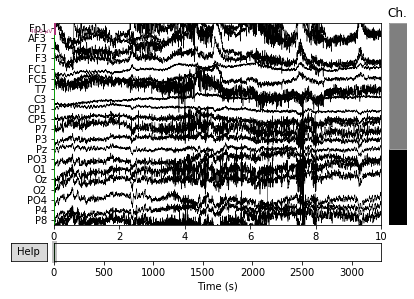

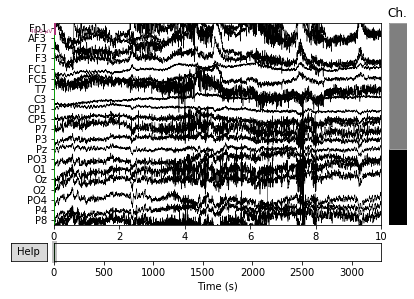

In [8]:
raw.plot()

In [9]:
raw.set_eeg_reference(ref_channels=['Cz']) #reference to the Cz node, common for biosig

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

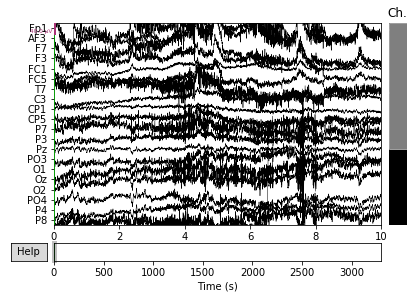

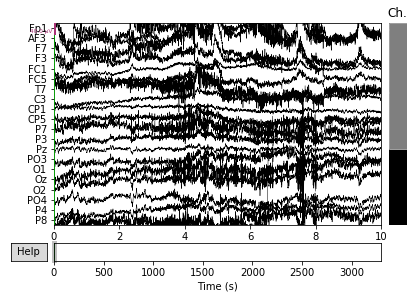

In [10]:
raw.plot()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


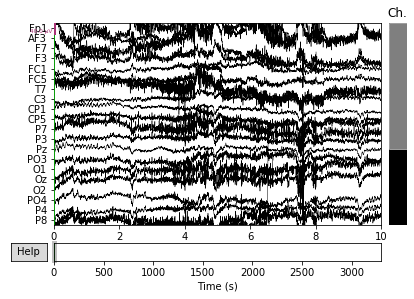

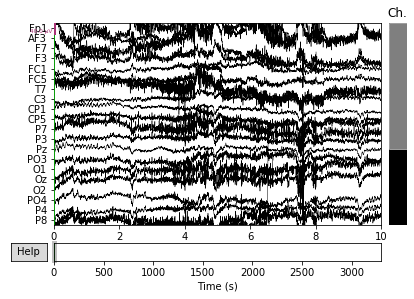

In [11]:
raw_avg=raw.copy().set_eeg_reference(ref_channels='average') #reference to the average (I think is more stable)
raw_avg.plot()

In [12]:
ssp_projectors = raw.info['projs']
raw.del_proj()

<RawEDF | s04.bdf, 32 x 1690112 (3301.0 s), ~412.7 MB, data loaded>

Effective window size : 4.000 (s)


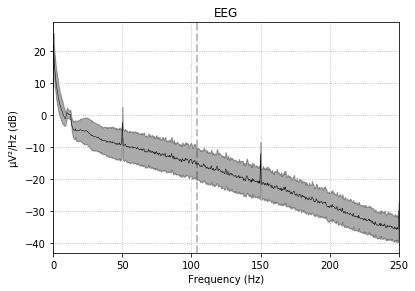

In [13]:
fig = raw_avg.plot_psd(tmax=np.inf, fmax=250, average=True) #check orginal PSD

Effective window size : 4.000 (s)


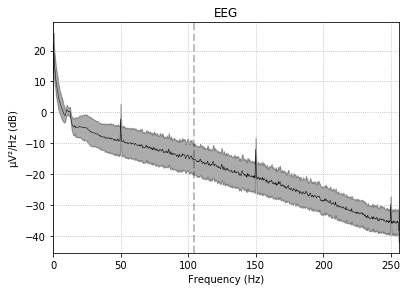

In [14]:
avg_psd=raw_avg.plot_psd(average=True)

Effective window size : 8.000 (s)


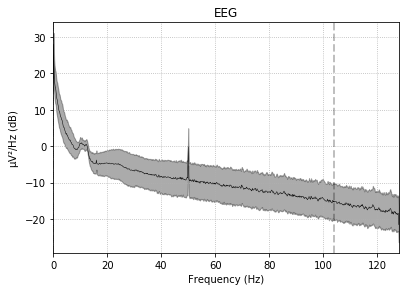

In [15]:
raw_avg_downsampled = raw_avg.copy().resample(sfreq=256) #check downsample PSD
fig=raw_avg_downsampled.plot_psd(average=True)

Effective window size : 8.000 (s)


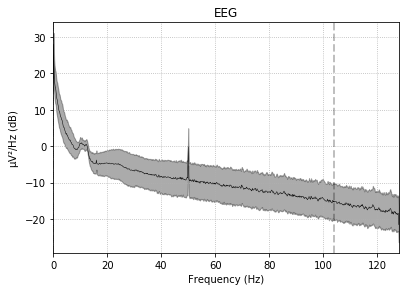

In [16]:
raw_avg_downsampled2 = raw_avg.copy().resample(sfreq=128) #check downsample PSD
avg_psd_128=raw_avg_downsampled.plot_psd(average=True)

In [17]:
df=raw_avg.to_data_frame(scalings=1e6) #convert to pandas
df.head()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0,-14455.503563,-12227.851429,-15334.220690,2417.027761,7097.956611,-5910.206853,5328.647381,12407.634300,8646.141251,...,-2150.557550,-3013.899705,10644.543808,-298.748471,-15697.345019,4108.118386,14041.631281,-21364.928296,5600.521878,-5590.863693
1,2,-14456.336570,-12233.809426,-15330.428704,2419.507248,7098.248603,-5904.539871,5334.126863,12410.207538,8646.964491,...,-2151.890555,-3015.201460,10642.148305,-300.175227,-15699.209273,4103.410387,14035.548285,-21372.011291,5600.626370,-5591.946699
2,4,-14460.655898,-12233.160013,-15329.154293,2420.656660,7098.554266,-5903.390459,5335.682524,12411.263200,8648.363903,...,-2153.116139,-3020.020787,10641.891469,-299.994563,-15699.059859,4103.434801,14033.791452,-21376.705618,5600.557034,-5591.859785
3,6,-14468.183227,-12229.406114,-15331.306633,2419.973068,7098.370673,-5904.730300,5336.405179,12410.985857,8647.586561,...,-2152.612233,-3022.141877,10642.957874,-300.771905,-15700.930950,4104.376205,14033.420359,-21379.982956,5599.029693,-5591.699629
4,8,-14476.405868,-12226.128776,-15332.560536,2419.969161,7099.273015,-5904.015458,5337.338771,12410.731951,8646.082657,...,-2151.866141,-3017.052042,10644.797714,-301.432060,-15701.216105,4105.591047,14035.635199,-21379.674363,5598.525788,-5591.891035


In [18]:
fs=512
stop_time=len(df)/(fs*60)

In [19]:
df['time']=np.linspace(0,stop_time,num=len(df))

In [20]:
df.head()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-14455.503563,-12227.851429,-15334.220690,2417.027761,7097.956611,-5910.206853,5328.647381,12407.634300,8646.141251,...,-2150.557550,-3013.899705,10644.543808,-298.748471,-15697.345019,4108.118386,14041.631281,-21364.928296,5600.521878,-5590.863693
1,0.000033,-14456.336570,-12233.809426,-15330.428704,2419.507248,7098.248603,-5904.539871,5334.126863,12410.207538,8646.964491,...,-2151.890555,-3015.201460,10642.148305,-300.175227,-15699.209273,4103.410387,14035.548285,-21372.011291,5600.626370,-5591.946699
2,0.000065,-14460.655898,-12233.160013,-15329.154293,2420.656660,7098.554266,-5903.390459,5335.682524,12411.263200,8648.363903,...,-2153.116139,-3020.020787,10641.891469,-299.994563,-15699.059859,4103.434801,14033.791452,-21376.705618,5600.557034,-5591.859785
3,0.000098,-14468.183227,-12229.406114,-15331.306633,2419.973068,7098.370673,-5904.730300,5336.405179,12410.985857,8647.586561,...,-2152.612233,-3022.141877,10642.957874,-300.771905,-15700.930950,4104.376205,14033.420359,-21379.982956,5599.029693,-5591.699629
4,0.000130,-14476.405868,-12226.128776,-15332.560536,2419.969161,7099.273015,-5904.015458,5337.338771,12410.731951,8646.082657,...,-2151.866141,-3017.052042,10644.797714,-301.432060,-15701.216105,4105.591047,14035.635199,-21379.674363,5598.525788,-5591.891035


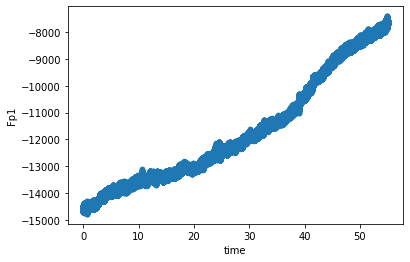

In [21]:
df.plot.scatter(x='time', y='Fp1')

In [22]:
df=df.iloc[0:60*60*512][:] #downsample to clip last couple minutes (noisy))

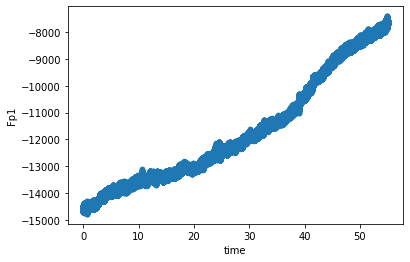

In [23]:
df.plot.scatter(x='time', y='Fp1')

In [24]:
df

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-14455.503563,-12227.851429,-15334.220690,2417.027761,7097.956611,-5910.206853,5328.647381,12407.634300,8646.141251,...,-2150.557550,-3013.899705,10644.543808,-298.748471,-15697.345019,4108.118386,14041.631281,-21364.928296,5600.521878,-5590.863693
1,0.000033,-14456.336570,-12233.809426,-15330.428704,2419.507248,7098.248603,-5904.539871,5334.126863,12410.207538,8646.964491,...,-2151.890555,-3015.201460,10642.148305,-300.175227,-15699.209273,4103.410387,14035.548285,-21372.011291,5600.626370,-5591.946699
2,0.000065,-14460.655898,-12233.160013,-15329.154293,2420.656660,7098.554266,-5903.390459,5335.682524,12411.263200,8648.363903,...,-2153.116139,-3020.020787,10641.891469,-299.994563,-15699.059859,4103.434801,14033.791452,-21376.705618,5600.557034,-5591.859785
3,0.000098,-14468.183227,-12229.406114,-15331.306633,2419.973068,7098.370673,-5904.730300,5336.405179,12410.985857,8647.586561,...,-2152.612233,-3022.141877,10642.957874,-300.771905,-15700.930950,4104.376205,14033.420359,-21379.982956,5599.029693,-5591.699629
4,0.000130,-14476.405868,-12226.128776,-15332.560536,2419.969161,7099.273015,-5904.015458,5337.338771,12410.731951,8646.082657,...,-2151.866141,-3017.052042,10644.797714,-301.432060,-15701.216105,4105.591047,14035.635199,-21379.674363,5598.525788,-5591.891035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690107,55.016536,-7651.918478,-11998.785446,-8934.822358,3775.372907,10875.047288,-8363.948413,-4850.861154,21099.403396,4453.746653,...,-1030.836962,-14197.062635,12004.732701,-4501.268050,-12824.846420,-631.743950,19602.093663,-14885.092613,11251.296593,1274.158778
1690108,55.016569,-7675.772926,-12000.046186,-8939.645591,3780.112156,10875.942795,-8362.427908,-4846.028155,21101.548900,4455.173409,...,-1032.378952,-14216.667091,12007.721953,-4501.997541,-12824.044664,-630.660944,19610.176656,-14889.478347,11250.942102,1273.960537
1690109,55.016602,-7690.407665,-12005.680942,-8939.874106,3780.289890,10876.776777,-8360.031428,-4833.944193,21102.882882,4456.444891,...,-1030.357471,-14233.114326,12009.993434,-4502.538555,-12826.148176,-628.451964,19611.323138,-14899.488095,11250.244837,1272.294524
1690110,55.016634,-7676.115699,-12006.170198,-8940.175864,3773.081895,10875.912521,-8358.083189,-4830.402207,21103.049874,4456.580633,...,-1029.127981,-14234.353581,12007.129181,-4504.215310,-12830.074926,-628.878721,19609.302634,-14912.633578,11248.505583,1270.930269


In [25]:
df

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
0,0.000000,-14455.503563,-12227.851429,-15334.220690,2417.027761,7097.956611,-5910.206853,5328.647381,12407.634300,8646.141251,...,-2150.557550,-3013.899705,10644.543808,-298.748471,-15697.345019,4108.118386,14041.631281,-21364.928296,5600.521878,-5590.863693
1,0.000033,-14456.336570,-12233.809426,-15330.428704,2419.507248,7098.248603,-5904.539871,5334.126863,12410.207538,8646.964491,...,-2151.890555,-3015.201460,10642.148305,-300.175227,-15699.209273,4103.410387,14035.548285,-21372.011291,5600.626370,-5591.946699
2,0.000065,-14460.655898,-12233.160013,-15329.154293,2420.656660,7098.554266,-5903.390459,5335.682524,12411.263200,8648.363903,...,-2153.116139,-3020.020787,10641.891469,-299.994563,-15699.059859,4103.434801,14033.791452,-21376.705618,5600.557034,-5591.859785
3,0.000098,-14468.183227,-12229.406114,-15331.306633,2419.973068,7098.370673,-5904.730300,5336.405179,12410.985857,8647.586561,...,-2152.612233,-3022.141877,10642.957874,-300.771905,-15700.930950,4104.376205,14033.420359,-21379.982956,5599.029693,-5591.699629
4,0.000130,-14476.405868,-12226.128776,-15332.560536,2419.969161,7099.273015,-5904.015458,5337.338771,12410.731951,8646.082657,...,-2151.866141,-3017.052042,10644.797714,-301.432060,-15701.216105,4105.591047,14035.635199,-21379.674363,5598.525788,-5591.891035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690107,55.016536,-7651.918478,-11998.785446,-8934.822358,3775.372907,10875.047288,-8363.948413,-4850.861154,21099.403396,4453.746653,...,-1030.836962,-14197.062635,12004.732701,-4501.268050,-12824.846420,-631.743950,19602.093663,-14885.092613,11251.296593,1274.158778
1690108,55.016569,-7675.772926,-12000.046186,-8939.645591,3780.112156,10875.942795,-8362.427908,-4846.028155,21101.548900,4455.173409,...,-1032.378952,-14216.667091,12007.721953,-4501.997541,-12824.044664,-630.660944,19610.176656,-14889.478347,11250.942102,1273.960537
1690109,55.016602,-7690.407665,-12005.680942,-8939.874106,3780.289890,10876.776777,-8360.031428,-4833.944193,21102.882882,4456.444891,...,-1030.357471,-14233.114326,12009.993434,-4502.538555,-12826.148176,-628.451964,19611.323138,-14899.488095,11250.244837,1272.294524
1690110,55.016634,-7676.115699,-12006.170198,-8940.175864,3773.081895,10875.912521,-8358.083189,-4830.402207,21103.049874,4456.580633,...,-1029.127981,-14234.353581,12007.129181,-4504.215310,-12830.074926,-628.878721,19609.302634,-14912.633578,11248.505583,1270.930269


In [56]:
# df.to_hdf('s05.h5',key='df')

In [26]:
path = '/media/tris/tris_files/DEAP_dataset/data_original/s01.bdf'
raw=mne.io.read_raw_bdf(path)
raw.load_data()
eeg_channels=raw.ch_names[0:32]
raw.pick_channels(eeg_channels) #select only the EEG channels
raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
raw_avg_256 = raw_avg.copy().resample(sfreq=256)
raw_avg_128 = raw_avg.copy().resample(sfreq=128)
df_512=raw_avg.to_data_frame(scalings=1e6)
df_256=raw_avg_256.to_data_frame(scalings=1e6)
df_128=raw_avg_128.to_data_frame(scalings=1e6)
df_512=df_512.iloc[0:60*60*512][:]
df_256=df_256.iloc[0:60*60*256][:]
df_128=df_128.iloc[0:60*60*256][:]
df_512.to_hdf('s01_512.h5',key='df_512')
df_256.to_hdf('s01_256.h5',key='df_256')
df_128.to_hdf('s01_128.h5',key='df_128')

for n in range (2,10):
    path = '/media/tris/tris_files/DEAP_dataset/data_original/s0'+str(n)+'.bdf'
    raw=mne.io.read_raw_bdf(path)
    raw.load_data()
    eeg_channels=raw.ch_names[0:32]
    raw.pick_channels(eeg_channels) #select only the EEG channels
    raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
    raw_avg_256 = raw_avg.copy().resample(sfreq=256)
    raw_avg_128 = raw_avg.copy().resample(sfreq=128)
    df_512=raw_avg.to_data_frame(scalings=1e6)
    df_256=raw_avg_256.to_data_frame(scalings=1e6)
    df_128=raw_avg_128.to_data_frame(scalings=1e6)
    df_512=df_512.iloc[0:60*60*512][:]
    df_256=df_256.iloc[0:60*60*256][:]
    df_128=df_128.iloc[0:60*60*256][:]
    df_512.to_hdf('s0'+str(n)+'_512.h5',key='df_512')
    df_256.to_hdf('s0'+str(n)+'_256.h5',key='df_256')
    df_128.to_hdf('s0'+str(n)+'_128.h5',key='df_128')
for n in range (10,33):
    path = '/media/tris/tris_files/DEAP_dataset/data_original/s'+str(n)+'.bdf'
    raw=mne.io.read_raw_bdf(path)
    raw.load_data()
    eeg_channels=raw.ch_names[0:32]
    raw.pick_channels(eeg_channels) #select only the EEG channels
    raw_avg=raw.copy().set_eeg_reference(ref_channels='average')
    raw_avg_256 = raw_avg.copy().resample(sfreq=256)
    raw_avg_128 = raw_avg.copy().resample(sfreq=128)
    df_512=raw_avg.to_data_frame(scalings=1e6)
    df_256=raw_avg_256.to_data_frame(scalings=1e6)
    df_128=raw_avg_128.to_data_frame(scalings=1e6)
    df_512=df_512.iloc[0:60*60*512][:]
    df_256=df_256.iloc[0:60*60*256][:]
    df_128=df_128.iloc[0:60*60*256][:]
    df_512.to_hdf('s'+str(n)+'_512.h5',key='df_512')
    df_256.to_hdf('s'+str(n)+'_256.h5',key='df_256')
    df_128.to_hdf('s'+str(n)+'_128.h5',key='df_128')

Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1980927  =      0.000 ...  3868.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1895935  =      0.000 ...  3702.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1989119  =      0.000 ...  3884.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custo

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2109439  =      0.000 ...  4119.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s26.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2003455  =      0.000 ...  3912.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s27.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1944575  =      0.000 ...  3797.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_ori

<ipython-input-26-25b2a0f6264d>:39: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s30.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1876479  =      0.000 ...  3664.998 secs...


<ipython-input-26-25b2a0f6264d>:39: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s31.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1892351  =      0.000 ...  3695.998 secs...


<ipython-input-26-25b2a0f6264d>:39: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /media/tris/tris_files/DEAP_dataset/data_original/s32.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1804287  =      0.000 ...  3523.998 secs...


<ipython-input-26-25b2a0f6264d>:39: RuntimeWarning: Channel names are not unique, found duplicates for: {''}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_bdf(path)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
